In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize

import matplotlib.pyplot as plt
import numpy as np
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

print(torch.__version__)
print(torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
device

2.0.0
0.15.1


device(type='mps')

In [8]:
import sys
sys.path.append('/Users/parkermoesta/Library/Mobile Documents/com~apple~CloudDocs/Generative Models/Generative_Deep_Learning_2nd_Edition/notebooks')

from utils import sample_batch, display

In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 4
LOAD_MODEL = False

In [3]:
from torchvision.datasets import CelebA
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import DataLoader

# Define the transformations: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to the desired size
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    # Normalize the image to the range [-1, 1] (this is what the generator of a GAN usually outputs)
    transforms.Normalize(mean=(0.25, 0.25, 0.25), std=(0.25, 0.25, 0.25))
])


In [37]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Create the dataset
dataset = CustomImageDataset(
    root_dir="/Users/parkermoesta/Library/Mobile Documents/com~apple~CloudDocs/Generative Models/Generative_Deep_Learning_2nd_Edition/notebooks/03_vae/03_vae_faces/data/celeba-dataset/celeba/img_align_celeba",  # Root directory where images are
    transform=transform,  # Transformations to apply to the images
)

# Create the data loader
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=4  # Number of worker processes for data loading
)


In [5]:
# Define the transformations: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to the desired size
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    # Normalize the image to the range [-1, 1] (this is what the generator of a GAN usually outputs)
   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset
dataset = CelebA(
    root="data/celeba-dataset",  # Root directory where images are downloaded to
    split="train",  # One of {'train', 'valid', 'test', 'all'}
    target_type="attr",  # Type of target to use, 'attr', 'identity', 'bbox', or 'landmarks'
    transform=transform,  # Transformations to apply to the images
    download=True  # Download the dataset if it's not already there
)

# Define the number of images you want to use
num_images = 10000

# Create a subset of the dataset
subset_data = torch.utils.data.Subset(dataset, range(num_images))

# Create the data loader
dataloader = DataLoader(
    subset_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=4  # Number of worker processes for data loading
)

Files already downloaded and verified


In [6]:
# Get a batch of images from the data loader
images, _ = next(iter(dataloader))
images.shape

torch.Size([128, 3, 64, 64])

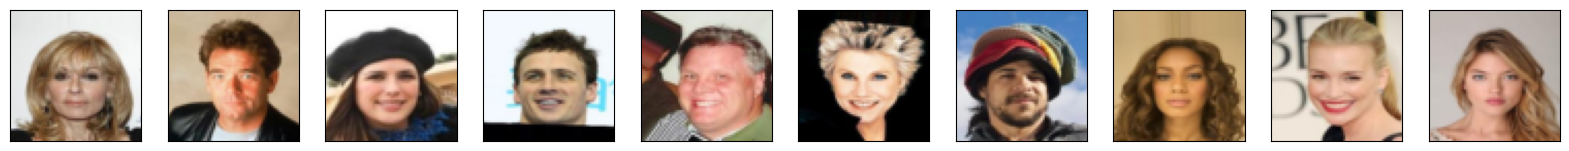

In [7]:
import matplotlib.pyplot as plt

def show_images(images, n=10):
    """
    Display a list of images in a single figure with matplotlib.
    
    Parameters:
    - images: a batch of images as a numpy array of shape (batch_size, channels, height, width)
    - n: the number of images to display
    """
    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(20, 4))
    for i in range(n):
        # Start next subplot.
        ax = figure.add_subplot(1, n, i + 1, xticks=[], yticks=[])
        # Display an image
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # The color channel is the last dimension in matplotlib
    plt.show()
def denormalize(images):
    images = images * 0.5 + 0.5  # denormalize
    return images
# Get a batch of images from the data loader
images, _ = next(iter(dataloader))

# Denormalize and show images
show_images(denormalize(images.numpy()))

In [7]:
len(dataloader)

79

In [8]:
print(1272*128)

162816


In [9]:
class Sampling(nn.Module):
    def forward(self, inputs):
        z_mean, z_log_var = inputs
        batch, dim = z_mean.shape
        epsilon = torch.randn(batch, dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [53]:
import torch
from torch import nn
from torch.nn import functional as F

class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, NUM_FEATURES, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(NUM_FEATURES)
        self.conv2 = nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(NUM_FEATURES)
        self.conv3 = nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(NUM_FEATURES)
        self.conv4 = nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(NUM_FEATURES)
        self.conv5 = nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(NUM_FEATURES)
        self.fc_mu = nn.Linear(NUM_FEATURES*2*2, z_dim)
        self.fc_var = nn.Linear(NUM_FEATURES*2*2, z_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.leaky_relu(self.bn5(self.conv5(x)))
        x = x.view(x.size(0), -1) # Flatten the tensor
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        z = self.sampling((mu, log_var))
        return mu, log_var, z



class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(z_dim, NUM_FEATURES*4*4)
        self.bn1 = nn.BatchNorm1d(NUM_FEATURES*4*4)
        self.deconv1 = nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(NUM_FEATURES)
        self.deconv2 = nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(NUM_FEATURES)
        self.deconv3 = nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(NUM_FEATURES)
        self.deconv4 = nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(NUM_FEATURES)
        self.deconv5 = nn.ConvTranspose2d(NUM_FEATURES, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc(x)))
        x = x.view(x.size(0), NUM_FEATURES, 4, 4) # Reshape the tensor to (batch_size, NUM_FEATURES, 4, 4)
        x = F.leaky_relu(self.bn2(self.deconv1(x)))
        x = F.leaky_relu(self.bn3(self.deconv2(x)))
        x = F.leaky_relu(self.bn4(self.deconv3(x)))
        x = F.leaky_relu(self.bn5(self.deconv4(x)))
        x = torch.sigmoid(self.deconv5(x)) # The output of the generator should be a sigmoid to generate images on a [0, 1] scale
        return x

class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mu, log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, mu, log_var

## Model V2

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dim, hidden_dims=None):
        super(Encoder, self).__init__()

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims=None):
        super(Decoder, self).__init__()

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=3,
                                      kernel_size=3, padding=1),
                            nn.Tanh())

    def forward(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 512, 2, 2)
        x = self.decoder(x)
        x = self.final_layer(x)
        return x

# Model V3 - BetaVAE

In [9]:
class BetaVAE(nn.Module):
    def __init__(self, in_channels, latent_dim, hidden_dims=None, beta=4, gamma=1000., max_capacity=25, Capacity_max_iter=1e5, loss_type='B'):
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter
        self.num_iter = 0

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=3,
                                      kernel_size=3, padding=1),
                            nn.Tanh())

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs):
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [10]:
def train(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data[0].to(device)
        optimizer.zero_grad()
        results = model(data)
        loss_terms = model.loss_function(*results, M_N = 1./len(dataloader))
        loss = loss_terms['loss']
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / len(dataloader.dataset)
    return train_loss

def test(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data = data[0].to(device)
            results = model(data)
            loss_terms = model.loss_function(*results, M_N = 1./len(dataloader))
            loss = loss_terms['loss']
            running_loss += loss.item()
    val_loss = running_loss / len(dataloader.dataset)
    return val_loss


In [11]:
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

model = BetaVAE(in_channels=3, latent_dim=Z_DIM, hidden_dims=[32, 64, 128, 256, 512], beta=4, gamma=1000., max_capacity=25, Capacity_max_iter=1e5, loss_type='B').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

EPOCHS = 40

for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss = train(model, dataloader, optimizer, device)
    val_loss = test(model, dataloader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Generate and save images after each epoch
    with torch.no_grad():
        samples = model.sample(10, device)
        torchvision.utils.save_image(samples, f"./generated_img_{epoch}.png")

  0%|          | 0/40 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  2%|▎         | 1/40 [00:55<35:58, 55.34s/it]

Epoch 1, Train Loss: 0.1990, Val Loss: 0.0116


  5%|▌         | 2/40 [01:55<36:43, 57.98s/it]

Epoch 2, Train Loss: 0.0060, Val Loss: 0.0031


  8%|▊         | 3/40 [02:49<34:35, 56.10s/it]

Epoch 3, Train Loss: 0.0117, Val Loss: 0.0065


 10%|█         | 4/40 [03:39<32:21, 53.92s/it]

Epoch 4, Train Loss: 0.0113, Val Loss: 0.0109


 12%|█▎        | 5/40 [04:30<30:44, 52.71s/it]

Epoch 5, Train Loss: 0.0124, Val Loss: 0.0077


 15%|█▌        | 6/40 [05:14<28:17, 49.93s/it]

Epoch 6, Train Loss: 0.0160, Val Loss: 0.0328


 18%|█▊        | 7/40 [06:05<27:34, 50.14s/it]

Epoch 7, Train Loss: 0.0120, Val Loss: 0.0162


 20%|██        | 8/40 [06:55<26:43, 50.09s/it]

Epoch 8, Train Loss: 0.0143, Val Loss: 0.0198


 22%|██▎       | 9/40 [07:45<25:55, 50.17s/it]

Epoch 9, Train Loss: 0.0165, Val Loss: 0.0078


 25%|██▌       | 10/40 [08:34<24:54, 49.83s/it]

Epoch 10, Train Loss: 0.0198, Val Loss: 0.0132


 28%|██▊       | 11/40 [09:25<24:16, 50.21s/it]

Epoch 11, Train Loss: 0.0187, Val Loss: 0.0088


 30%|███       | 12/40 [10:21<24:11, 51.85s/it]

Epoch 12, Train Loss: 0.0242, Val Loss: 0.0131


 32%|███▎      | 13/40 [11:17<23:56, 53.19s/it]

Epoch 13, Train Loss: 0.0233, Val Loss: 0.0099


 35%|███▌      | 14/40 [12:13<23:25, 54.04s/it]

Epoch 14, Train Loss: 0.0110, Val Loss: 0.0193


 38%|███▊      | 15/40 [13:07<22:30, 54.02s/it]

Epoch 15, Train Loss: 0.0136, Val Loss: 0.0174


 40%|████      | 16/40 [14:01<21:38, 54.08s/it]

Epoch 16, Train Loss: 0.0110, Val Loss: 0.0212


 42%|████▎     | 17/40 [14:56<20:45, 54.15s/it]

Epoch 17, Train Loss: 0.0247, Val Loss: 0.0325


 45%|████▌     | 18/40 [15:49<19:46, 53.93s/it]

Epoch 18, Train Loss: 0.0133, Val Loss: 0.0291


 48%|████▊     | 19/40 [16:46<19:13, 54.91s/it]

Epoch 19, Train Loss: 0.0179, Val Loss: 0.0276


 50%|█████     | 20/40 [17:42<18:20, 55.04s/it]

Epoch 20, Train Loss: 0.0102, Val Loss: 0.0138


 52%|█████▎    | 21/40 [18:40<17:43, 55.98s/it]

Epoch 21, Train Loss: 0.0163, Val Loss: 0.0268


 55%|█████▌    | 22/40 [19:37<16:52, 56.26s/it]

Epoch 22, Train Loss: 0.0125, Val Loss: 0.0286


 57%|█████▊    | 23/40 [20:36<16:12, 57.20s/it]

Epoch 23, Train Loss: 0.0092, Val Loss: 0.0310


 60%|██████    | 24/40 [21:34<15:17, 57.36s/it]

Epoch 24, Train Loss: 0.0121, Val Loss: 0.0648


 62%|██████▎   | 25/40 [22:28<14:06, 56.44s/it]

Epoch 25, Train Loss: 0.0085, Val Loss: 0.2197


 65%|██████▌   | 26/40 [23:25<13:10, 56.43s/it]

Epoch 26, Train Loss: 0.0106, Val Loss: 0.0519


 68%|██████▊   | 27/40 [24:20<12:09, 56.13s/it]

Epoch 27, Train Loss: 0.0075, Val Loss: 0.0311


 70%|███████   | 28/40 [25:16<11:12, 56.08s/it]

Epoch 28, Train Loss: 0.0110, Val Loss: 0.0435


 72%|███████▎  | 29/40 [26:12<10:17, 56.15s/it]

Epoch 29, Train Loss: 0.0176, Val Loss: 0.0514


 75%|███████▌  | 30/40 [27:09<09:24, 56.43s/it]

Epoch 30, Train Loss: 0.0099, Val Loss: 0.0559


 78%|███████▊  | 31/40 [28:05<08:24, 56.07s/it]

Epoch 31, Train Loss: 0.0064, Val Loss: 0.0483


 80%|████████  | 32/40 [29:00<07:26, 55.78s/it]

Epoch 32, Train Loss: 0.0059, Val Loss: 0.0469


 82%|████████▎ | 33/40 [29:55<06:29, 55.71s/it]

Epoch 33, Train Loss: 0.0070, Val Loss: 0.0365


 85%|████████▌ | 34/40 [30:49<05:30, 55.14s/it]

Epoch 34, Train Loss: 0.0068, Val Loss: 0.0599


 88%|████████▊ | 35/40 [31:46<04:38, 55.77s/it]

Epoch 35, Train Loss: 0.0066, Val Loss: 0.0483


 90%|█████████ | 36/40 [32:42<03:42, 55.64s/it]

Epoch 36, Train Loss: 0.0060, Val Loss: 0.0436


 92%|█████████▎| 37/40 [33:38<02:47, 55.81s/it]

Epoch 37, Train Loss: 0.0050, Val Loss: 0.0491


 95%|█████████▌| 38/40 [34:39<01:54, 57.46s/it]

Epoch 38, Train Loss: 0.0058, Val Loss: 0.0489


 98%|█████████▊| 39/40 [35:34<00:56, 56.78s/it]

Epoch 39, Train Loss: 0.0051, Val Loss: 0.0729


100%|██████████| 40/40 [36:31<00:00, 54.80s/it]

Epoch 40, Train Loss: 0.0048, Val Loss: 0.0491


In [19]:
EPOCHS = 40

for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss = train(model, dataloader, optimizer, device)
    val_loss = test(model, dataloader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Generate and save images after each epoch
    with torch.no_grad():
        samples = model.sample(10, device)
        torchvision.utils.save_image(samples, f"./generated_img_{epoch}.png")

  2%|▎         | 1/40 [00:32<21:14, 32.68s/it]

Epoch 1, Train Loss: 0.0067, Val Loss: 0.0461


  5%|▌         | 2/40 [01:03<20:10, 31.84s/it]

Epoch 2, Train Loss: 0.0055, Val Loss: 0.0552


  8%|▊         | 3/40 [01:36<19:44, 32.00s/it]

Epoch 3, Train Loss: 0.0112, Val Loss: 0.2877


 10%|█         | 4/40 [02:07<19:04, 31.78s/it]

Epoch 4, Train Loss: 0.0078, Val Loss: 0.0718


 12%|█▎        | 5/40 [02:39<18:31, 31.76s/it]

Epoch 5, Train Loss: 0.0064, Val Loss: 0.0473


 15%|█▌        | 6/40 [03:10<17:56, 31.68s/it]

Epoch 6, Train Loss: 0.0056, Val Loss: 0.0575


 18%|█▊        | 7/40 [03:45<17:55, 32.60s/it]

Epoch 7, Train Loss: 0.0044, Val Loss: 0.0775


 20%|██        | 8/40 [04:16<17:11, 32.25s/it]

Epoch 8, Train Loss: 0.0050, Val Loss: 0.0512


 22%|██▎       | 9/40 [04:48<16:31, 31.99s/it]

Epoch 9, Train Loss: 0.0046, Val Loss: 0.0979


 25%|██▌       | 10/40 [05:19<15:49, 31.65s/it]

Epoch 10, Train Loss: 0.0070, Val Loss: 0.0914


 28%|██▊       | 11/40 [05:50<15:13, 31.51s/it]

Epoch 11, Train Loss: 0.0038, Val Loss: 0.0747


 30%|███       | 12/40 [06:21<14:40, 31.45s/it]

Epoch 12, Train Loss: 0.0038, Val Loss: 0.0634


 32%|███▎      | 13/40 [06:56<14:36, 32.47s/it]

Epoch 13, Train Loss: 0.0047, Val Loss: 0.0660


 35%|███▌      | 14/40 [07:27<13:55, 32.15s/it]

Epoch 14, Train Loss: 0.0043, Val Loss: 0.0716


 38%|███▊      | 15/40 [08:00<13:27, 32.28s/it]

Epoch 15, Train Loss: 0.0045, Val Loss: 0.1457


 40%|████      | 16/40 [08:31<12:48, 32.02s/it]

Epoch 16, Train Loss: 0.0054, Val Loss: 0.0840


 42%|████▎     | 17/40 [09:09<12:52, 33.57s/it]

Epoch 17, Train Loss: 0.0046, Val Loss: 0.1134


 45%|████▌     | 18/40 [09:47<12:52, 35.10s/it]

Epoch 18, Train Loss: 0.0049, Val Loss: 0.1376


 48%|████▊     | 19/40 [10:24<12:30, 35.74s/it]

Epoch 19, Train Loss: 0.0047, Val Loss: 0.1055


 50%|█████     | 20/40 [10:55<11:24, 34.25s/it]

Epoch 20, Train Loss: 0.0043, Val Loss: 0.0719


 52%|█████▎    | 21/40 [11:27<10:38, 33.63s/it]

Epoch 21, Train Loss: 0.0043, Val Loss: 0.0710


 55%|█████▌    | 22/40 [11:58<09:51, 32.84s/it]

Epoch 22, Train Loss: 0.0045, Val Loss: 0.6094


 57%|█████▊    | 23/40 [12:30<09:11, 32.47s/it]

Epoch 23, Train Loss: 0.0067, Val Loss: 0.0672


 60%|██████    | 24/40 [13:03<08:40, 32.51s/it]

Epoch 24, Train Loss: 0.0042, Val Loss: 0.0789


 62%|██████▎   | 25/40 [13:37<08:14, 32.95s/it]

Epoch 25, Train Loss: 0.0053, Val Loss: 0.0733


 65%|██████▌   | 26/40 [14:14<08:00, 34.35s/it]

Epoch 26, Train Loss: 0.0034, Val Loss: 0.0690


 68%|██████▊   | 27/40 [14:51<07:35, 35.04s/it]

Epoch 27, Train Loss: 0.0033, Val Loss: 0.1371


 70%|███████   | 28/40 [15:30<07:16, 36.38s/it]

Epoch 28, Train Loss: 0.0037, Val Loss: 0.0769


 72%|███████▎  | 29/40 [16:02<06:24, 34.94s/it]

Epoch 29, Train Loss: 0.0029, Val Loss: 0.0718


 75%|███████▌  | 30/40 [16:34<05:40, 34.03s/it]

Epoch 30, Train Loss: 0.0032, Val Loss: 0.0981


 78%|███████▊  | 31/40 [17:09<05:08, 34.29s/it]

Epoch 31, Train Loss: 0.0037, Val Loss: 0.0852


 80%|████████  | 32/40 [17:49<04:49, 36.17s/it]

Epoch 32, Train Loss: 0.0036, Val Loss: 0.0809


 82%|████████▎ | 33/40 [18:22<04:06, 35.15s/it]

Epoch 33, Train Loss: 0.0052, Val Loss: 0.0778


 85%|████████▌ | 34/40 [18:53<03:22, 33.81s/it]

Epoch 34, Train Loss: 0.0041, Val Loss: 0.0823


 88%|████████▊ | 35/40 [19:23<02:43, 32.65s/it]

Epoch 35, Train Loss: 0.0034, Val Loss: 0.0851


 90%|█████████ | 36/40 [19:52<02:07, 31.79s/it]

Epoch 36, Train Loss: 0.0044, Val Loss: 0.1003


 92%|█████████▎| 37/40 [20:23<01:33, 31.29s/it]

Epoch 37, Train Loss: 0.0057, Val Loss: 0.0974


 95%|█████████▌| 38/40 [20:54<01:02, 31.26s/it]

Epoch 38, Train Loss: 0.0040, Val Loss: 0.0978


 98%|█████████▊| 39/40 [21:26<00:31, 31.53s/it]

Epoch 39, Train Loss: 0.0042, Val Loss: 0.1214


100%|██████████| 40/40 [21:57<00:00, 32.93s/it]

Epoch 40, Train Loss: 0.0037, Val Loss: 0.1017


# Vanilla VAE

In [ ]:
class BetaVAE(nn.Module):
    def __init__(self, in_channels, latent_dim, hidden_dims=None, beta=4, gamma=1000., max_capacity=25, Capacity_max_iter=1e5, loss_type='B'):
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter
        self.num_iter = 0

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=3,
                                      kernel_size=3, padding=1),
                            nn.Tanh())

    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return [mu, log_var]

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs):
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_loss

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [20]:
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

model = BetaVAE(in_channels=3, latent_dim=128, hidden_dims=[32, 64, 128, 256, 512], gamma=1000., max_capacity=25, Capacity_max_iter=1e5, loss_type='B').to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

EPOCHS = 40

for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss = train(model, dataloader, optimizer, device)
    val_loss = test(model, dataloader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Generate and save images after each epoch
    with torch.no_grad():
        samples = model.sample(10, device)
        torchvision.utils.save_image(samples, f"./generated_img_{epoch}.png")

  2%|▎         | 1/40 [00:32<21:00, 32.31s/it]

Epoch 1, Train Loss: 0.1350, Val Loss: 0.0037


  5%|▌         | 2/40 [01:02<19:33, 30.88s/it]

Epoch 2, Train Loss: 0.0043, Val Loss: 0.0063


  8%|▊         | 3/40 [01:32<18:59, 30.79s/it]

Epoch 3, Train Loss: 0.0069, Val Loss: 0.0244


 10%|█         | 4/40 [02:03<18:21, 30.58s/it]

Epoch 4, Train Loss: 0.0103, Val Loss: 0.0499


 12%|█▎        | 5/40 [02:34<17:56, 30.74s/it]

Epoch 5, Train Loss: 0.0121, Val Loss: 0.0068


 15%|█▌        | 6/40 [03:04<17:17, 30.52s/it]

Epoch 6, Train Loss: 0.0090, Val Loss: 0.0153


 18%|█▊        | 7/40 [03:34<16:47, 30.54s/it]

Epoch 7, Train Loss: 0.0078, Val Loss: 0.0094


 20%|██        | 8/40 [04:09<17:00, 31.90s/it]

Epoch 8, Train Loss: 0.0109, Val Loss: 0.0216


 22%|██▎       | 9/40 [04:41<16:28, 31.90s/it]

Epoch 9, Train Loss: 0.0166, Val Loss: 0.0311


 25%|██▌       | 10/40 [05:13<16:00, 32.01s/it]

Epoch 10, Train Loss: 0.0255, Val Loss: 0.0328


 28%|██▊       | 11/40 [05:52<16:31, 34.18s/it]

Epoch 11, Train Loss: 0.0150, Val Loss: 0.0148


 30%|███       | 12/40 [06:28<16:10, 34.67s/it]

Epoch 12, Train Loss: 0.0118, Val Loss: 0.0086


 32%|███▎      | 13/40 [07:05<15:54, 35.35s/it]

Epoch 13, Train Loss: 0.0176, Val Loss: 0.0138


 35%|███▌      | 14/40 [07:39<15:08, 34.94s/it]

Epoch 14, Train Loss: 0.0139, Val Loss: 0.0214


 38%|███▊      | 15/40 [08:10<14:02, 33.72s/it]

Epoch 15, Train Loss: 0.0138, Val Loss: 0.0101


 40%|████      | 16/40 [08:41<13:08, 32.85s/it]

Epoch 16, Train Loss: 0.0127, Val Loss: 0.0137


 42%|████▎     | 17/40 [09:12<12:21, 32.25s/it]

Epoch 17, Train Loss: 0.0216, Val Loss: 0.0318


 45%|████▌     | 18/40 [09:43<11:45, 32.07s/it]

Epoch 18, Train Loss: 0.0167, Val Loss: 0.0387


 48%|████▊     | 19/40 [10:14<11:06, 31.73s/it]

Epoch 19, Train Loss: 0.0091, Val Loss: 0.0230


 50%|█████     | 20/40 [10:48<10:48, 32.41s/it]

Epoch 20, Train Loss: 0.0092, Val Loss: 0.0176


 52%|█████▎    | 21/40 [11:20<10:13, 32.28s/it]

Epoch 21, Train Loss: 0.0086, Val Loss: 0.0153


 55%|█████▌    | 22/40 [11:53<09:42, 32.34s/it]

Epoch 22, Train Loss: 0.0091, Val Loss: 0.0192


 57%|█████▊    | 23/40 [12:26<09:15, 32.69s/it]

Epoch 23, Train Loss: 0.0102, Val Loss: 0.0188


 60%|██████    | 24/40 [13:00<08:48, 33.01s/it]

Epoch 24, Train Loss: 0.0095, Val Loss: 0.0201


 62%|██████▎   | 25/40 [13:34<08:17, 33.19s/it]

Epoch 25, Train Loss: 0.0098, Val Loss: 0.0246


 65%|██████▌   | 26/40 [14:10<07:58, 34.16s/it]

Epoch 26, Train Loss: 0.0102, Val Loss: 0.0278


 68%|██████▊   | 27/40 [14:51<07:49, 36.15s/it]

Epoch 27, Train Loss: 0.0072, Val Loss: 0.0266


 70%|███████   | 28/40 [15:26<07:12, 36.00s/it]

Epoch 28, Train Loss: 0.0045, Val Loss: 0.0374


 72%|███████▎  | 29/40 [16:01<06:31, 35.58s/it]

Epoch 29, Train Loss: 0.0102, Val Loss: 0.0532


 75%|███████▌  | 30/40 [16:35<05:50, 35.09s/it]

Epoch 30, Train Loss: 0.0087, Val Loss: 0.0288


 78%|███████▊  | 31/40 [17:08<05:09, 34.44s/it]

Epoch 31, Train Loss: 0.0083, Val Loss: 0.0406


 80%|████████  | 32/40 [17:41<04:31, 33.96s/it]

Epoch 32, Train Loss: 0.0052, Val Loss: 0.0361


 82%|████████▎ | 33/40 [18:16<03:59, 34.27s/it]

Epoch 33, Train Loss: 0.0060, Val Loss: 0.0481


 85%|████████▌ | 34/40 [18:55<03:33, 35.66s/it]

Epoch 34, Train Loss: 0.0071, Val Loss: 0.0599


 88%|████████▊ | 35/40 [19:37<03:07, 37.57s/it]

Epoch 35, Train Loss: 0.0065, Val Loss: 0.0445


 90%|█████████ | 36/40 [20:14<02:30, 37.56s/it]

Epoch 36, Train Loss: 0.0036, Val Loss: 0.0350


 92%|█████████▎| 37/40 [21:03<02:02, 40.87s/it]

Epoch 37, Train Loss: 0.0048, Val Loss: 0.1373


 95%|█████████▌| 38/40 [21:41<01:20, 40.15s/it]

Epoch 38, Train Loss: 0.0048, Val Loss: 0.0463


 98%|█████████▊| 39/40 [22:16<00:38, 38.67s/it]

Epoch 39, Train Loss: 0.0057, Val Loss: 0.0447


100%|██████████| 40/40 [22:51<00:00, 34.29s/it]

Epoch 40, Train Loss: 0.0037, Val Loss: 0.0428


## BREAK

In [54]:
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = F.mse_loss(recon_x, x)
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BETA * recon_loss + kld_loss, recon_loss, kld_loss

def train(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kld_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data[0].to(device)
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(data)
        loss, recon_loss, kld_loss = vae_loss(reconstruction, data, mu, log_var)
        loss.backward()
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kld_loss += kld_loss.item()
        optimizer.step()
    train_loss = running_loss / len(dataloader.dataset)
    train_recon_loss = running_recon_loss / len(dataloader.dataset)
    train_kld_loss = running_kld_loss / len(dataloader.dataset)
    return train_loss, train_recon_loss, train_kld_loss

def test(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kld_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data = data[0].to(device)
            reconstruction, mu, log_var = model(data)
            loss, recon_loss, kld_loss = vae_loss(reconstruction, data, mu, log_var)
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kld_loss += kld_loss.item()
    val_loss = running_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    val_kld_loss = running_kld_loss / len(dataloader.dataset)
    return val_loss, val_recon_loss, val_kld_loss

In [56]:
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

encoder = Encoder(Z_DIM).to(device)
decoder = Decoder(Z_DIM).to(device)
model = VAE(encoder, decoder).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

EPOCHS = 40

for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss, train_recon_loss, train_kld_loss = train(model, dataloader, optimizer, device)
    val_loss, val_recon_loss, val_kld_loss = test(model, dataloader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Recon Loss: {train_recon_loss:.4f}, Train KLD Loss: {train_kld_loss:.4f}, Val Loss: {val_loss:.4f}, Val Recon Loss: {val_recon_loss:.4f}, Val KLD Loss: {val_kld_loss:.4f}")

    # Generate and save images after each epoch
    with torch.no_grad():
        random_latent_vectors = torch.randn(10, Z_DIM).to(device)
        generated_images = model.decoder(random_latent_vectors)
        torchvision.utils.save_image(generated_images, f"./generated_img_{epoch}.png")


  2%|▎         | 1/40 [10:12<6:38:03, 612.40s/it]

Epoch 1, Train Loss: 0.1366, Train Recon Loss: 0.0006, Train KLD Loss: 0.1341, Val Loss: 0.0075, Val Recon Loss: 0.0006, Val KLD Loss: 0.0051


  5%|▌         | 2/40 [21:13<6:45:55, 640.93s/it]

Epoch 2, Train Loss: 0.0058, Train Recon Loss: 0.0006, Train KLD Loss: 0.0033, Val Loss: 0.0046, Val Recon Loss: 0.0006, Val KLD Loss: 0.0022


  8%|▊         | 3/40 [32:28<6:44:50, 656.50s/it]

Epoch 3, Train Loss: 0.0041, Train Recon Loss: 0.0006, Train KLD Loss: 0.0017, Val Loss: 0.0034, Val Recon Loss: 0.0006, Val KLD Loss: 0.0009


 10%|█         | 4/40 [43:11<6:30:46, 651.29s/it]

Epoch 4, Train Loss: 0.0033, Train Recon Loss: 0.0006, Train KLD Loss: 0.0009, Val Loss: 0.0035, Val Recon Loss: 0.0006, Val KLD Loss: 0.0011


 12%|█▎        | 5/40 [53:41<6:15:24, 643.55s/it]

Epoch 5, Train Loss: 0.0030, Train Recon Loss: 0.0006, Train KLD Loss: 0.0006, Val Loss: 0.0028, Val Recon Loss: 0.0006, Val KLD Loss: 0.0004


 15%|█▌        | 6/40 [1:04:08<6:01:26, 637.84s/it]

Epoch 6, Train Loss: 0.0028, Train Recon Loss: 0.0006, Train KLD Loss: 0.0004, Val Loss: 0.0027, Val Recon Loss: 0.0006, Val KLD Loss: 0.0003


 18%|█▊        | 7/40 [1:14:41<5:50:01, 636.40s/it]

Epoch 7, Train Loss: 0.0027, Train Recon Loss: 0.0006, Train KLD Loss: 0.0003, Val Loss: 0.0026, Val Recon Loss: 0.0006, Val KLD Loss: 0.0002


 20%|██        | 8/40 [1:25:12<5:38:28, 634.64s/it]

Epoch 8, Train Loss: 0.0026, Train Recon Loss: 0.0006, Train KLD Loss: 0.0002, Val Loss: 0.0027, Val Recon Loss: 0.0006, Val KLD Loss: 0.0003


 22%|██▎       | 9/40 [1:35:43<5:27:16, 633.43s/it]

Epoch 9, Train Loss: 0.0026, Train Recon Loss: 0.0006, Train KLD Loss: 0.0002, Val Loss: 0.0025, Val Recon Loss: 0.0006, Val KLD Loss: 0.0001


 25%|██▌       | 10/40 [1:46:13<5:16:08, 632.29s/it]

Epoch 10, Train Loss: 0.0025, Train Recon Loss: 0.0006, Train KLD Loss: 0.0001, Val Loss: 0.0025, Val Recon Loss: 0.0006, Val KLD Loss: 0.0001


 28%|██▊       | 11/40 [1:56:46<5:05:47, 632.69s/it]

Epoch 11, Train Loss: 0.0025, Train Recon Loss: 0.0006, Train KLD Loss: 0.0001, Val Loss: 0.0025, Val Recon Loss: 0.0006, Val KLD Loss: 0.0000


 30%|███       | 12/40 [2:07:19<4:55:14, 632.66s/it]

Epoch 12, Train Loss: 0.0026, Train Recon Loss: 0.0006, Train KLD Loss: 0.0002, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: 0.0000


 32%|███▎      | 13/40 [2:17:54<4:45:03, 633.46s/it]

Epoch 13, Train Loss: 0.0024, Train Recon Loss: 0.0006, Train KLD Loss: 0.0000, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: 0.0000


 35%|███▌      | 14/40 [2:28:45<4:36:47, 638.74s/it]

Epoch 14, Train Loss: 0.0025, Train Recon Loss: 0.0006, Train KLD Loss: 0.0000, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: -0.0000


 38%|███▊      | 15/40 [2:40:01<4:30:50, 650.03s/it]

Epoch 15, Train Loss: 0.0024, Train Recon Loss: 0.0006, Train KLD Loss: -0.0000, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: -0.0000


 40%|████      | 16/40 [2:51:20<4:23:32, 658.84s/it]

Epoch 16, Train Loss: 0.0026, Train Recon Loss: 0.0006, Train KLD Loss: 0.0001, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: 0.0000


 42%|████▎     | 17/40 [3:02:32<4:14:03, 662.76s/it]

Epoch 17, Train Loss: 0.0024, Train Recon Loss: 0.0006, Train KLD Loss: 0.0000, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: -0.0000


 45%|████▌     | 18/40 [3:13:42<4:03:47, 664.90s/it]

Epoch 18, Train Loss: 0.0024, Train Recon Loss: 0.0006, Train KLD Loss: -0.0000, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: -0.0000


 45%|████▌     | 18/40 [3:24:53<4:10:25, 683.00s/it]

Epoch 19, Train Loss: 0.0024, Train Recon Loss: 0.0006, Train KLD Loss: -0.0000, Val Loss: 0.0024, Val Recon Loss: 0.0006, Val KLD Loss: -0.0000


OSError: [Errno 28] No space left on device: './generated_img_18.png'

In [12]:
# save the model
torch.save(model.state_dict(), 'vae_celab_faces_v5.pth')

In [ ]:
def display(images, n=10, size=(20, 3), cmap=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    images = images.permute(0, 2, 3, 1)  # change from (B, C, H, W) to (B, H, W, C)
    images = images.numpy()  # convert to numpy

    # denormalize images
    images = (images * 0.5) + 0.5

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        plt.axis("off")

    plt.show()

In [13]:
def display(images, n=10, size=(20, 3), cmap=None):
    """
    Displays n random images from each one of the supplied arrays.
    """
    images = images.permute(0, 2, 3, 1)  # change from (B, C, H, W) to (B, H, W, C)
    images = images.numpy()  # convert to numpy

    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    # denormalize images

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap=cmap)
        plt.axis("off")

        

    plt.show()

Example real faces


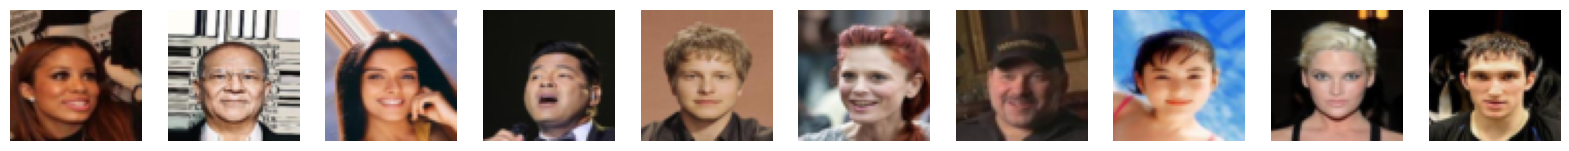

Reconstructions


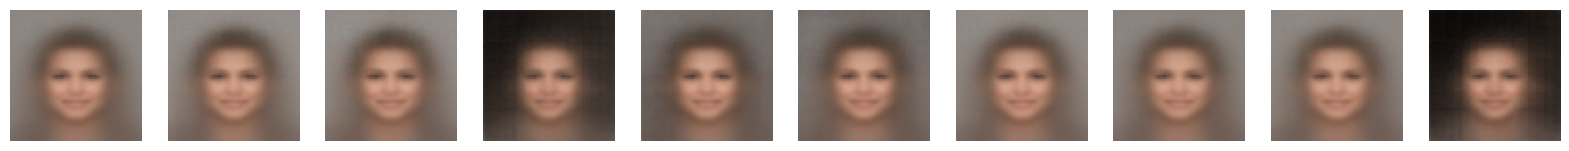

In [14]:
# Select a subset of the test set
batches_to_predict = 1
example_images = next(iter(dataloader))  # get a batch from the dataloader
example_images = example_images[0].to(device)  # get the images from the batch and move to device

# Create autoencoder predictions and display
with torch.no_grad():  # we don't need gradients for prediction
    reconstructions, _,_,_ = model(example_images)

# Move tensors back to CPU for visualization
example_images = example_images.cpu()
reconstructions = reconstructions.cpu()

print("Example real faces")
display(example_images)
print("Reconstructions")
#denormalize
display(denormalize(reconstructions))


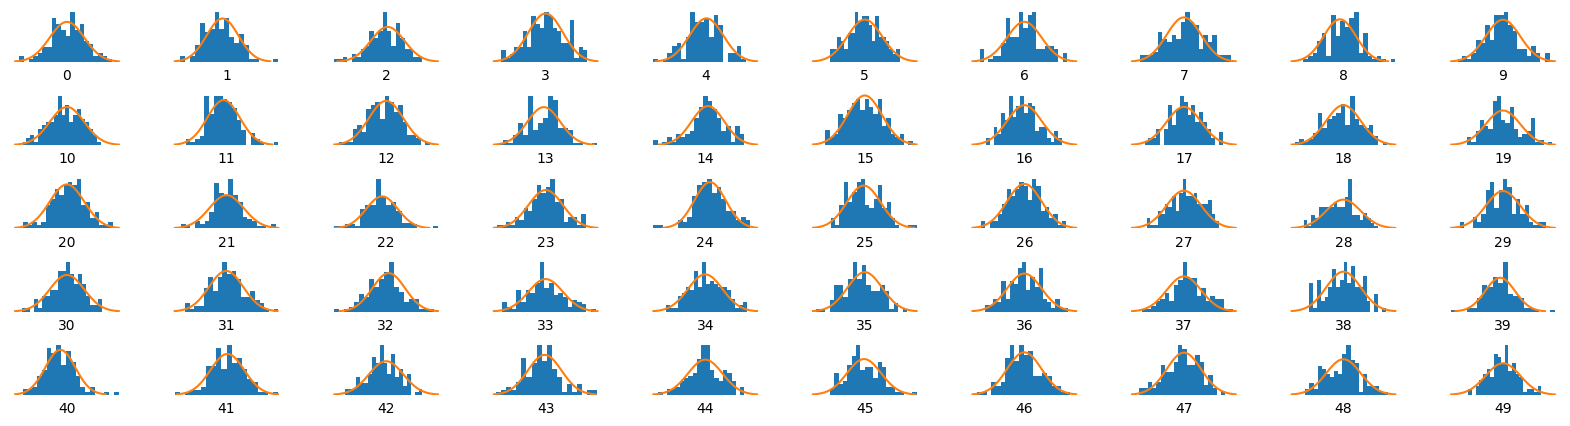

In [22]:
# import norm
from scipy.stats import norm

example_images = example_images.to(device).float()
mu, log_var = model.encode(example_images)
z = model.reparameterize(mu, log_var).cpu().detach().numpy()

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## Generate new faces

In [23]:
num_samples = 10  # number of samples you want to generate
z = torch.randn(num_samples, model.latent_dim).to(device)  # sample from the latent space
generated_images = model.decode(z)  # decode the samples to generate new images


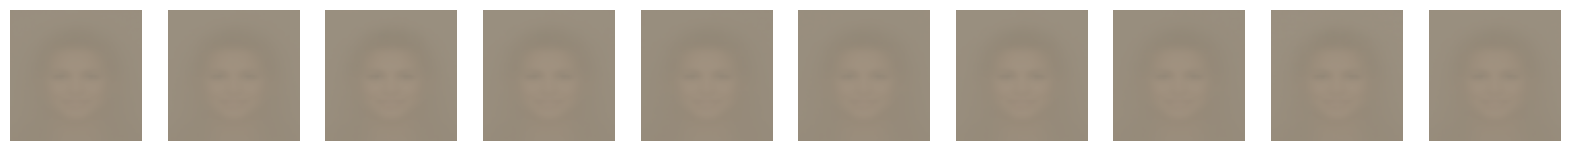

In [29]:
import matplotlib.pyplot as plt
# assuming that mean and std are the mean and standard deviation of your dataset
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

def denormalize(image):
    return image * std.cpu().numpy() + mean.cpu().numpy()

# denormalize the generated images
generated_images = denormalize(generated_images)

# move the images to cpu and convert to numpy arrays
generated_images = generated_images
# plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].transpose(1, 2, 0))
    ax.axis('off')
plt.show()